In [2]:
import os
import cv2
from scipy import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fracture
import DIC.DIC as dic
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

Run complete


In [17]:
#csv파일 형식 바꾸기!

"""setting values"""
path = r'E:\experiment data\aluminum\2021-05-03\1'

slice_x1 = 120
slice_x2 = 191
slice_y1 = 344
slice_y2 = 475
file_list = os.listdir(path+'/img')

result = []
for file in file_list:
    if file.endswith(".jpg"):
        im = cv2.imread(os.path.join(path,'img', file), cv2.IMREAD_GRAYSCALE)
        im_calculate = np.array(im)
        img_box = im_calculate[slice_y1:slice_y2, slice_x1:slice_x2]

        ave = np.average(img_box)
        result = np.append(result, [ave])

result= result - result[0]
print('Finish')


Finish


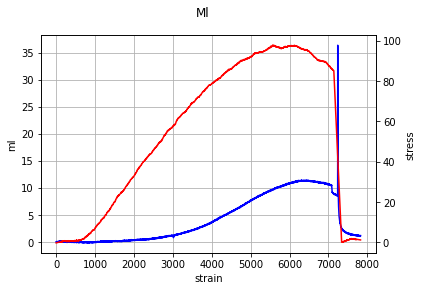

In [18]:
ml_avg = np.copy(result)
from scipy.signal import savgol_filter

max_range = 15000
tension_data = np.array(pd.read_csv(path+'/tension.csv', encoding='CP949'))

time, strain, stress = tension_data[:, 0], tension_data[:, 4]*10/25, tension_data[:, 3]*3000/18
# ml_avg[3545:] = ml_avg[3545:] + 1.4
stress = savgol_filter(stress[0:max_range],201,1)
strain = savgol_filter(strain[0:max_range],201,1)
# ml_avg = savgol_filter(ml_avg[0:max_range],2001,1)
ml_avg =  ml_avg[0:max_range]
time = time[0:max_range]


title = 'ml'
fig, ax = plt.subplots()
ax1 = ax.twinx()
fig.suptitle('Ml')
ax.set_xlabel('strain')
ax.set_ylabel('ml')
ax1.set_ylabel('stress')
ax.plot(time, ml_avg, color='b', label="Average Ml(Same mask)")
ax1.plot(time, stress, color='r', label=" stress")
ax.grid()
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)

983


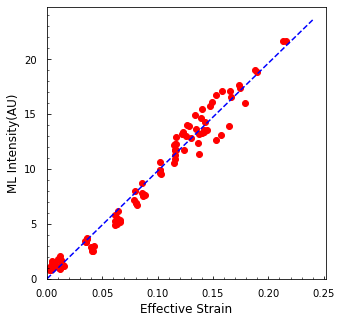

In [35]:
"""
Matlab코드 여러 Dic데이터있는경우
path = 'E:\experiment data\aluminum\2021-03-04\DIC_img\data'

for i=1:1:22
uu=handles_ncorr.data_dic.displacements(i).plot_u_cur_formatted;
vv=handles_ncorr.data_dic.displacements(i).plot_v_cur_formatted;
exx=handles_ncorr.data_dic.strains(i).plot_exx_cur_formatted;
eyy=handles_ncorr.data_dic.strains(i).plot_eyy_cur_formatted;
exy=handles_ncorr.data_dic.strains(i).plot_exy_cur_formatted;

save([path,'/', num2str(i), '_exx', '.mat'],'exx')
save([path,'/', num2str(i), '_exy', '.mat'],'exy')
save([path,'/', num2str(i), '_eyy', '.mat'],'eyy')
save([path,'/', num2str(i), '_uu', '.mat'],'uu')
save([path,'/', num2str(i), '_vv', '.mat'],'vv')

end

"""

"""setting values"""

image = dic.load_file(path+'/DIC_img')

ref = image[list(image.keys())[0]]

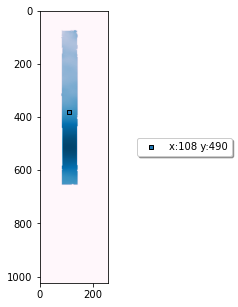

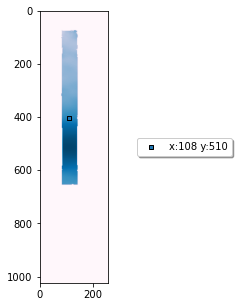

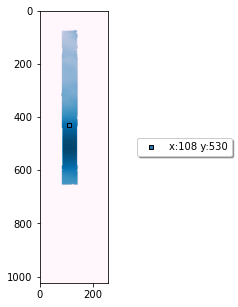

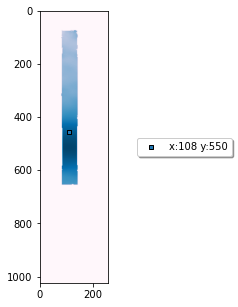

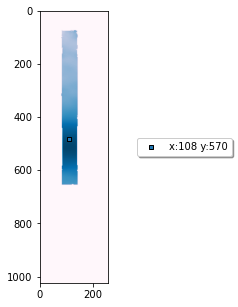

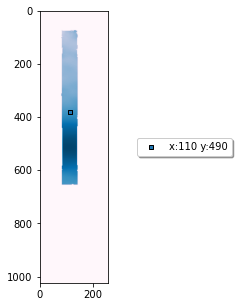

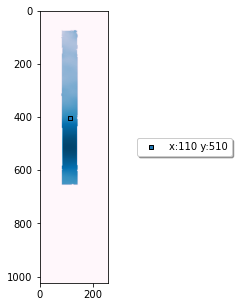

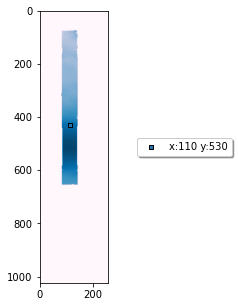

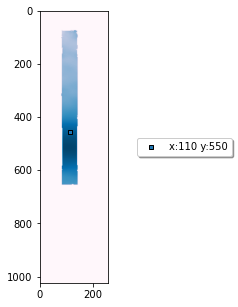

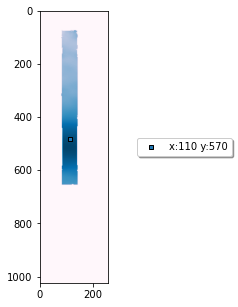

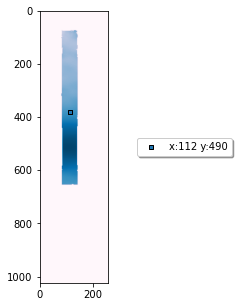

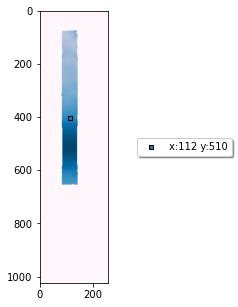

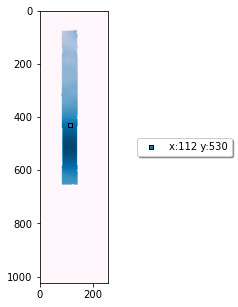

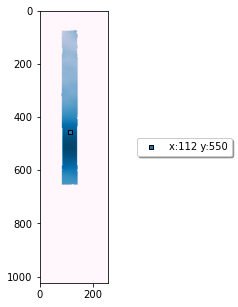

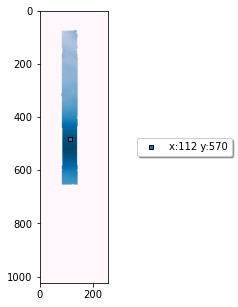

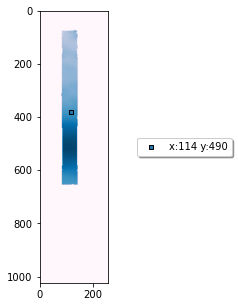

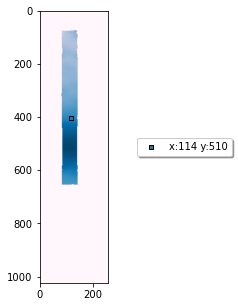

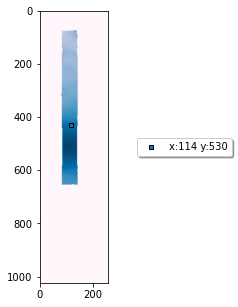

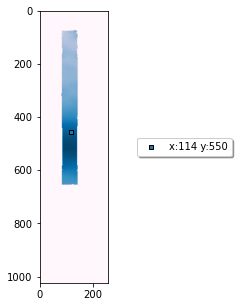

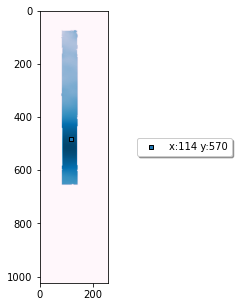

938


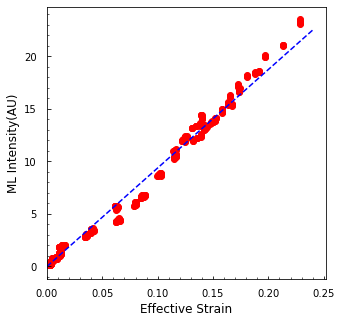

In [57]:
ref_xy_list = []
x_list=np.arange(108,115,2)
y_list=np.arange(490,580,20)
for xx in x_list:
    for yy in y_list:
        ref_xy_list.append([xx,yy])


ratio = 0.04

df = pd.DataFrame(columns=['image_name', 'voltage_strain','using_DIC_mask_strain','voltage_stress',
                           'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy','ml_average'])

for ref_x, ref_y in ref_xy_list:
    # for num in [12,,8,9,10,13,14,15,16,17,18,19,20,21,22]:
    for num in range(1,22+1):
        file_num = str(num)
        uu = io.loadmat(path+'/DIC_img/data/'+file_num+'_uu.mat')['uu']
        vv = io.loadmat(path+'/DIC_img/data/'+file_num+'_vv.mat')['vv']
        uu_resize = cv2.resize(uu,(0,0),fx=2, fy=2 )
        vv_resize = cv2.resize(vv,(0,0),fx=2, fy=2 )

        exx = io.loadmat(path+'/DIC_img/data/'+file_num+'_exx.mat')['exx']
        eyy = io.loadmat(path+'/DIC_img/data/'+file_num+'_eyy.mat')['eyy']
        exy = io.loadmat(path+'/DIC_img/data/'+file_num+'_exy.mat')['exy']
        ee = fracture.effective_strain(exx, eyy, exy)
        exx_resize = cv2.resize(exx,(0,0),fx=2, fy=2 )
        eyy_resize = cv2.resize(eyy,(0,0),fx=2, fy=2 )
        exy_resize = cv2.resize(exy,(0,0),fx=2, fy=2 )
        ee_resize = cv2.resize(ee,(0,0),fx=2, fy=2 )

        ee_mask = np.where(ee_resize>0, 255, ee_resize*0).astype('uint8')
        ml_image = image[list(image.keys())[num]]
        ml_image = cv2.GaussianBlur(ml_image,(0,0),15)
        mask_ml = dic.find_zone(cv2.copyTo(ml_image, ee_mask))[10:-10,10:-10]
        if num == 1:
            ref_image = cv2.copyTo(image[list(image.keys())[0]], cv2.imread(path+'/DIC_img/mask.png'))
            ref = dic.find_zone(ref_image)[10:-10,10:-10]


        gas = cv2.GaussianBlur(mask_ml[:,:,1],(0,0),15)

        cur_y = np.round(ref_y+vv_resize[ref_y,ref_x]/ratio,1).astype('int')
        cur_x = np.round(ref_x+uu_resize[ref_y,ref_x]/ratio,1).astype('int')

        ref_local_ml = cv2.GaussianBlur(image[list(image.keys())[0]],(0,0),15)[ref_y-10 : ref_y+10 , ref_x-10 : ref_x+10]
        # ref_local_ml = image[list(image.keys())[0]][ref_y-10 : ref_y+10 , ref_x-10 : ref_x+10]
        local_ee = np.average(ee_resize[cur_y-10 : cur_y+10 , cur_x-10: cur_x+10])
        local_ml = np.average(ml_image[cur_y-10 : cur_y+10 , cur_x-10: cur_x+10]) - np.average(ref_local_ml)

        image_name = int(list(image.keys())[num].split('_')[1])
        voltage_strain = strain[int(list(image.keys())[num].split('_')[1])]
        voltage_stress = stress[int(list(image.keys())[num].split('_')[1])]
        using_DIC_mask_strain = np.average(dic.find_zone(ee_resize)[10:-10,10:-10])
        using_DIC_mask_average = np.average(mask_ml[:,:,1])-np.average(ref)
        if num>5 and num<10:
            local_ml = local_ml + 1.5
        local_ml = local_ml
        local_ee = local_ee
        DIC_eyy = np.average(dic.find_zone(eyy))
        DIC_exx = np.average(dic.find_zone(exx))
        DIC_exy = np.average(dic.find_zone(exy))
        ml_average = ml_avg[int(list(image.keys())[num].split('_')[1])]
        row = pd.Series([image_name, voltage_strain,voltage_stress,using_DIC_mask_strain,
                         using_DIC_mask_average, local_ml, local_ee,DIC_exx, DIC_eyy, DIC_exy,ml_average],
                    index=['image_name', 'voltage_strain','voltage_stress','using_DIC_mask_strain',
                           'using_DIC_mask_average', 'local_ml', 'local_ee','DIC_exx', 'DIC_eyy', 'DIC_exy','ml_average'])
        df = df.append(row, ignore_index=True)

    # fig, ax = plt.subplots(1, 3 , constrained_layout=True)
    # fig.suptitle(list(image.keys())[num] + 'strain : ' + str(np.round(strain[int(list(image.keys())[num].split('_')[1])],3)))
    #
    # ax0 = ax[0].imshow(cv2.addWeighted(ml_image[:,:,2],1, ee_mask,0.06,-40),cmap='gray')
    # # ax0 = ax[0].imshow(cv2.addWeighted(ml_image[:,:,2],1, ee_mask,0.06,-40),cmap='gray')
    # ax[0].set_title('ML ROI')
    # # ax[0].scatter(cur_x, cur_y,color='red', marker='s', s=10)
    #
    # ax1 = ax[1].imshow(ee_resize, cmap='jet', vmin=0, vmax=0.25)
    # ax[1].set_title('Effective\n strain')
    # # ax[1].scatter(cur_x, cur_y,color='white', marker='s', s=10)
    # plt.colorbar(ax1,ax=ax[1])
    #
    # gas = cv2.flip(gas,0)
    # ax[2].imshow(gas)
    # ax2 = ax[2].contourf(gas,cmap='jet', vmin=75, vmax=116)
    # ax3 = ax[2].contour(gas,colors='black',linewidths=1)
    # ax[2].invert_yaxis()
    # plt.colorbar(ax2, ax=ax[2])
    # # ax[2].axis('off')
    # ax[2].set_title('ML')
    # # plt.savefig(path+'/'+list(image.keys())[num]+'.png', dpi=300)
    # plt.show()
    # plt.close()

    plt.imshow(ee_resize, cmap='PuBu', vmin=0, vmax=0.25) ##네킹부분 국부
    plt.scatter(cur_x, cur_y, marker='s', s=10  ,label='x:'+str(ref_x) + ' y:'+str(ref_y), edgecolors='black')
    plt.legend()
    plt.legend(loc='center right', bbox_to_anchor=(2.9, 0.5), fancybox=True, shadow=True)
    # plt.savefig(path+'/국부 점으로찍은위치6.png', dpi=300)
    plt.show()
    plt.close()
# df

"""최소자승법"""
lms_list = []
for k in range(0,5000):
    i = k*0.1
    lms = np.sum(((i * df.local_ee) - df.local_ml)**2)
    lms_list.append(lms)
np.argmin(lms_list)

plt.rcParams["figure.figsize"] = (5,5)
plt.scatter(df.local_ee, df.local_ml, color='red',zorder=1)
plt.plot([0,0.24],[0,0.24*0.1*np.argmin(lms_list)], 'b--',zorder=2)
# plt.plot(df.using_DIC_mask_strain, df.ml_average, color='black')
plt.xlabel('Effective Strain')
plt.ylabel('ML Intensity(AU)')
# plt.grid()
# plt.xlim(0,0.15)
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
plt.xlim(0,)
# plt.ylim(0,)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.savefig(path+'/ee_ml.png', dpi=300, bbox_inches='tight',  pad_inches=0)

b = np.vstack((np.arange(0,0.23,0.0005), np.arange(0,0.23,0.0005)*88.5)).transpose()
print(np.argmin(lms_list))
np.savetxt(path+'/effective_strain_ml_파이날.csv',b)

x,y 85 125 340 460 
 ml: 16 
 strain: 0.16411351360232973


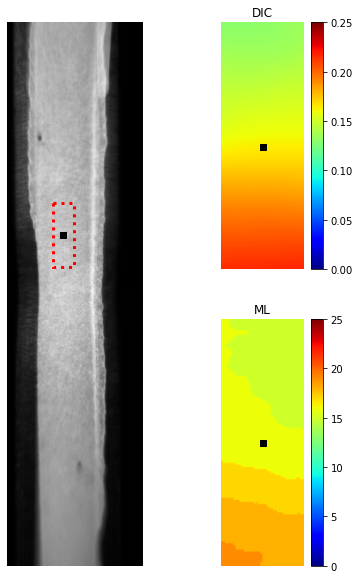

In [433]:
x, y, width, hight=85,340,40,120

fig = plt.figure(figsize=(6, 10))
gs = GridSpec(nrows=2, ncols=2)
# First axes
ax0 = fig.add_subplot(gs[0:2, 0])
ax0.imshow(ml_image[:,:,2],cmap='gray')
ax0.set_axis_off()
ax0.scatter(x+width/2 , y+hight/2,marker='s', color='black')
ax0.add_patch(
     patches.Rectangle(
        (x, y),
        width,
        hight,
        edgecolor = 'red',
        facecolor = 'black',
        fill=False, lw=3, ls=':'
     ) )

ax1 = fig.add_subplot(gs[0,1])
dic = ax1.imshow(ee_resize[y:y+hight,x:x+width], cmap='jet', vmin=0, vmax=0.25)


ax1.set_axis_off()
fig.colorbar(dic,ax=ax1)
ax1.scatter(width/2 , hight/2,marker='s', color='black')
ax1.set_title('DIC')


ax2 = fig.add_subplot(gs[1, 1])

gas2 = cv2.GaussianBlur(ml_image[:,:,2][y:y+hight,x:x+width]-90,(0,0),25)
ax2.scatter(width/2 , hight/2,marker='s', color='black')
ax2.set_title('ML')

ml = ax2.imshow(gas2,cmap='jet',vmin=0,vmax=25)

ax2.set_axis_off()
fig.colorbar(ml,ax=ax2)



y_ = int(hight/2)
x_ = int(width/2)

print(
    "x,y",x,x+width, y, y+hight,'\n ml:',
    gas2[y_,x_],'\n strain:',
    ee_resize[y:y+hight,x:x+width][y_,x_]
)
plt.savefig(path+'/'+list(image.keys())[num]+'gogo.png', dpi=300,pad_inches=0)
plt.show()
plt.close()


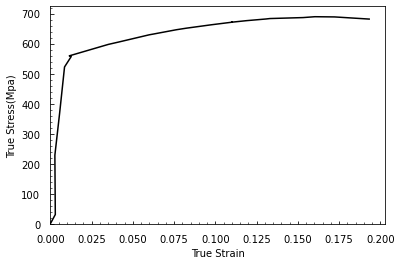

In [46]:
# title = 'Effective strain vs Stress'
plt.tick_params(direction='in', pad=10,which='both')
plt.minorticks_on()
stress, strain = fracture.true_ss(df.voltage_stress, df.local_ee)

stress = np.insert(stress, 0, 0)
strain = np.insert(strain, 0, 0)
plt.plot(strain, stress, color='black')
plt.xlabel('True Strain')
plt.ylabel('True Stress(Mpa)')
# plt.grid()
plt.xlim(0,)
plt.ylim(0,)
plt.savefig(path+'/true_%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)
plt.show()

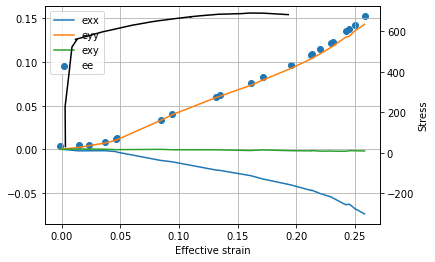

In [8]:
fig, ax = plt.subplots()
ax1 = ax.twinx()
title = 'Effective strain vs Strain'
ax1.plot(strain, stress, color='black')
ax.plot(df.voltage_strain, df.DIC_exx, label='exx')
ax.plot(df.voltage_strain, df.DIC_eyy,label='eyy')
ax.plot(df.voltage_strain, df.DIC_exy, label='exy')
ax.scatter(df.voltage_strain, df.using_DIC_mask_strain, label='ee')
ax.set_xlabel('Effective strain')
ax1.set_ylabel('Stress')
ax1.set_ylim(-350,)
ax.legend()
ax.grid()
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)
plt.show()


In [9]:
ml_df = pd.read_pickle('only_ml.pkl')
ml_df

FileNotFoundError: [Errno 2] No such file or directory: 'only_ml.pkl'

In [ ]:
plt.plot(df.local_ee, df.voltage_stress, color='red',label='dic_ml')
plt.plot(ml_df.local_ee, ml_df.voltage_stress, color='blue',label='only ml')
plt.legend()
plt.grid()
title = '비교샷'
plt.savefig(path+'/%s.png'%title, dpi=300, bbox_inches='tight',  pad_inches=0)